<a href="https://colab.research.google.com/github/MohdRad/ML_Course/blob/main/sklearn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we will go more in depth with sklearn, we will see how how to **tune hyperparameters** and **generate learning curves**.

Start by importing the related packages.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regressor
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting
from sklearn.svm import SVR # Support Vector Machine
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import shuffle
# New packages (were not imported in the previous tutorial)
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV
# To plot learning curves
import matplotlib.pyplot as plt


In this tutorial we will use different dataset, the dataset is about predicting student perforamce based on different variables like study hours, previous scores, and others.

In [3]:
# Import the data and shuffle it (randomize it)
df = shuffle(pd.read_csv('Student_Performance.csv'))
# Display the data
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
2918,2,73,Yes,4,5,49.0
3901,4,80,No,8,0,63.0
9381,6,50,No,5,2,35.0
350,5,83,No,5,0,68.0
3018,9,50,No,6,3,44.0
...,...,...,...,...,...,...
750,3,54,No,5,5,34.0
8392,1,49,Yes,5,7,24.0
3337,9,66,No,8,5,64.0
9107,3,56,Yes,7,9,34.0


The output is `Performance Index`, a `float` between `0.0` and `100.0`. The inputs are 4 features shown in df above.

In [4]:
# Define the inputs, drop the output and non numeric column 'Extracurricular Activities'
X = np.array(df.drop(['Performance Index','Extracurricular Activities'], axis=1))

# Define the output
y = np.array(df['Performance Index'])

# Since we have only one output,
# we need to make it 2D array to avoid problems later in the scaling
y = y.reshape(-1,1)

Now we split the data into training (80\%) and testing (20\%).

In [5]:
L = int(0.8*len(X))
X_train = X[:L]
y_train = y[:L]
X_test = X[L:]
y_test = y[L:]

Now we need to scale the data.

In [6]:
# X scaler
X_scaler = MinMaxScaler()
# Let the scaler defines the maximum and the minimum
X_scaler.fit(X_train)
# Apply scaling to train X data
X_train_scaled = X_scaler.transform(X_train)
# test data
X_scaler.fit(X_test)
X_test_scaled = X_scaler.transform(X_test)

# y scaler
y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_scaler.fit(y_test)

MinMaxScaler()

Let's start with `DecsionTree Regressor`, we generate the learning curves that shows when training should be stopped. This is important because in some cases, using more data causes overfitting; the model performance starts to decrease as you use more data.  

The y-axis of the learning curves is one of the metrics like Mean Absolute Error or Coefficient of detrmination. However, the x-axis is defined based on how the algorithm is trained. For Decision Tree, the x-axis is the size of the data used. For examples, we have 7000 training samples, these can be divided into 20 batches of 350 observations, the training score is recoreded at each of the 350 samples.

Another important aspect in `learning_curves` is the cross validation (`cv`). The common cross validation approach is **k-fold** cross validation. The training is divided in equal `k folds` where `k` is defined by the user. In our examples, our training data can be devided into **8** folds, each fold has 1000 samples. For **8 loops**, the model uses 7 folds (7000 data points) for training and and 1 fold (1000 points) for validation. Consequently, we will have 8 training and 8 testing metrics, the common approach is to average these metrics.     

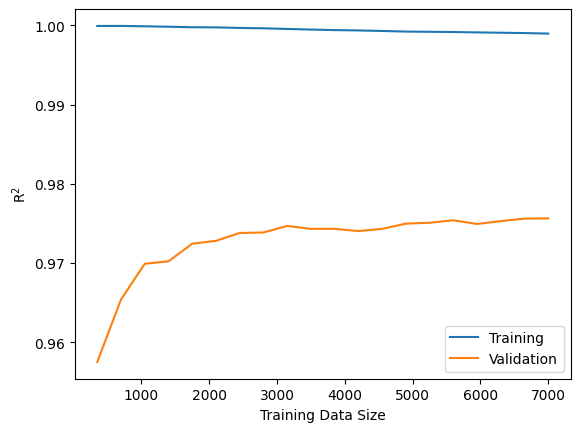

In [7]:
# Define the regressor
dtr = DecisionTreeRegressor()
# learning curves must be assigned to three variables
# (1) size of samples for n-th batches, (2) train_scores, (3) val_scores
# We must follow this order to avoid the confusion between train and validation
train_sizes, train_scores, val_scores = learning_curve(dtr,                     # the ML model
                                                        X_train_scaled,          # Training input
                                                        y_train_scaled,          # Training output
                                                        cv=8,                    # Cross validation
                                                        n_jobs=3,                # number of jobs to be done in parallel, this is useful to reduce the computing time
                                                        train_sizes=np.linspace(0.05, 1.0, 20), # The fraction of data to be used in each of the 20 batches.
                                                        scoring='r2')  # The metric to be used on the y-axis, I used R^2, other options can be checked by  # import sklearn
                                                                                                                                                           # sklearn.metrics.get_scorer_names()
# For each of 20 batches, we will get 8 metrics, see test_scores
# We want to compute their average, np.mean is used for this purpose
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Learning curves plot
fig, ax = plt.subplots()
plt.plot(train_sizes, train_scores_mean, label='Training')
plt.plot(train_sizes, val_scores_mean, label='Validation')
ax.set_ylabel('R$^2$')
ax.set_xlabel('Training Data Size')
plt.legend()


In contrast with Boston housing, here you can see the problem is much easier on Decision Tree. The training R$^2$ is almost one while the validaiton R$^2$ is 0.975. The training R$^2$ expected to be better (higher) than the validation one as shown in the figure above, however, it should not be much better. If the validation R$^2$ is much **lower** (worse) than the training one, this is called **overfitting**.

The validation is similar to the testing; the model does not see the true output as in the training, that is why the validation R$^2$ is expected to be lower, but as mentioned, it should not be much lower, this is **overfitting**.

In other words, your model is a student that performs well in the exam preperation where he/she has the answers, but does not do well in the exam.

In this case, the training R$^2$ after using 7000 is $\frac{0.998-0.975}{0.998}\%=2.3\%$ higher than the validation one. This is GREAT! There is an overfitting but it is small, as long as the difference is less than 10\%. As the realtive difference increases, the model starts to overfit the data and this model is not valid and cannot be used even if the training metric is PERFECT.

In [ ]:
# train
dtr.fit(X_train_scaled,y_train_scaled)
# predict
y_predict = dtr.predict(X_test_scaled)

# y_predict is scaled, we need to rescale it back to the original scale
y_pred = y_scaler.inverse_transform(y_predict.reshape(-1,1))

# Metrics
# Mean Absolute Error
MAE = mean_absolute_error(y_test,y_predict)
# Coefficient of determination
R2 = r2_score(y_test, y_pred)

print('MAE =', MAE)
print('R2 =', R2)


MAE = 54.8242037037037
R2 = 0.9739194797981637


You can see that the testing R$^2$ is very close to the validation one because as mentioned, they are similar and the model does not see the true output.

The last thing to discuss is the hyperparameters tuning using `GridSearchCV`. Here we will search for the optimal values for two Decision hyperparameters `min_samples_split` and `min_samples_leaf`.

In [13]:
# We need to define the list of hyperparameters as a dictionary
# Make sure to write the hyperparameters correctly
# Make sure to assign valid values, you may need to read the documentation of the model you use
# The values are given in a list [].

grid = {'min_samples_split':[2,3,5,7,10],
        'min_samples_leaf':[1,3,5,7,9]}

grid_dtr = GridSearchCV(dtr,   # Decision Tree Model
                    grid,      # The grid
                    scoring='r2',
                    n_jobs=3,
                    cv=8)
# Train the model
grid_dtr.fit(X_train_scaled,y_train_scaled)

# Print the best values for the two hyperparameters
print('The Best Hyperparameters')
print(grid_dtr.best_params_)

# Predict
y_predict = grid_dtr.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_predict.reshape(-1,1))

# Metrics
# Mean Absolute Error
MAE = mean_absolute_error(y_test,y_predict)
# Coefficient of determination
R2 = r2_score(y_test, y_pred)

print('MAE =', MAE)
print('R2 =', R2)


The Best Hyperparameters
{'min_samples_leaf': 9, 'min_samples_split': 7}
MAE = 54.79065721949638
R2 = 0.9835309266368076


You can see here that R$^2$ increased from 0.974 to 0.983 after we searched for optimal values.

As an exercise, plot the learning curves and do grid search for random forest regressor. Make a grid for the following hyperparameters: `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`